<a href="https://colab.research.google.com/github/devyaniii12/ML_PROJECT/blob/main/LOAN_DEFAULT_REDICTION_USING_MACHINE_LEARNING_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#importing libraries and models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import shap

In [21]:
# Load dataset
df = pd.read_csv(r'/content/bankloans.csv')

In [22]:
# Step 1: Data Cleaning and Formatting
print("Missing values before imputation:\n", df.isnull().sum())
imputer = SimpleImputer(strategy='most_frequent')
df['default'] = imputer.fit_transform(df[['default']])
print("Missing values after imputation:\n", df.isnull().sum())

Missing values before imputation:
 age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     450
dtype: int64
Missing values after imputation:
 age         0
ed          0
employ      0
address     0
income      0
debtinc     0
creddebt    0
othdebt     0
default     0
dtype: int64


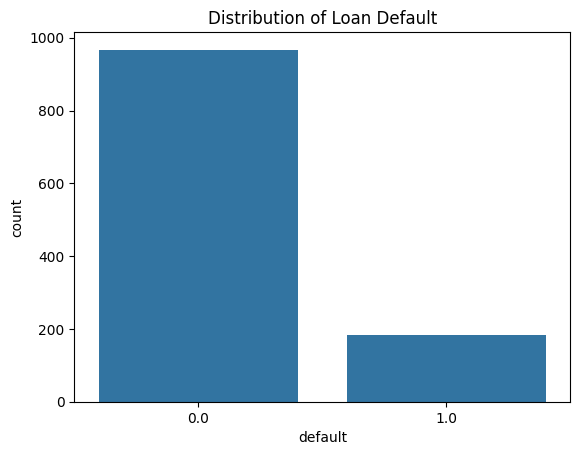

In [23]:
# Step 2: Exploratory Data Analysis (EDA)
sns.countplot(x='default', data=df)
plt.title('Distribution of Loan Default')
plt.show()


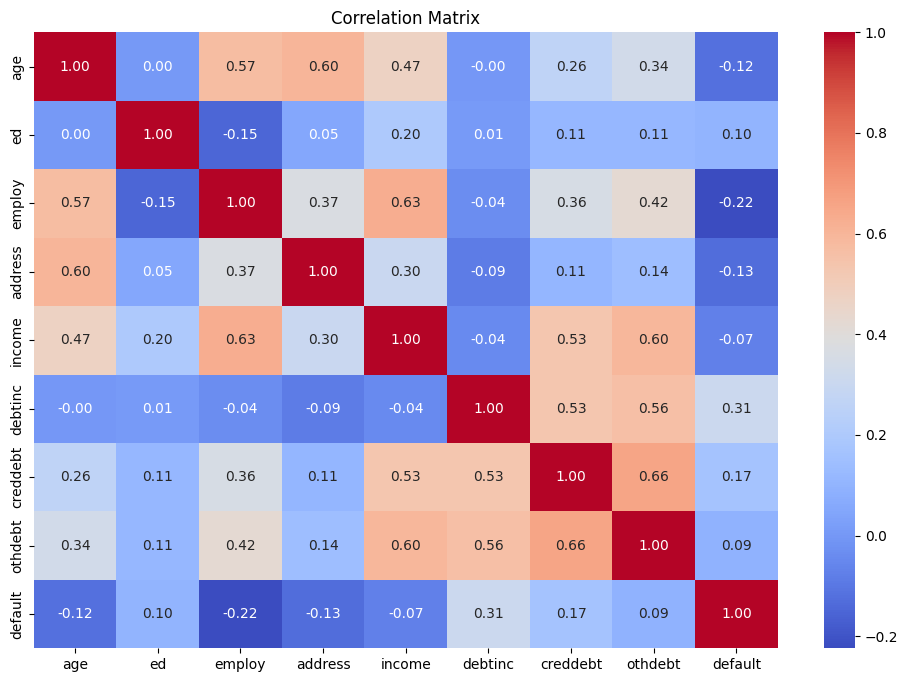

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [25]:
# Step 3: Feature Engineering and Scaling
numerical_cols = ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [26]:
# Step 4: Split the dataset into features (X) and target (y)
X = df.drop('default', axis=1)
y = df['default']

In [27]:
# Step 5: Split the data into training (64%), validation (16%), and testing (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [28]:
# Step 6: Define models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
# Initialize performance summary DataFrame
performance_summary = []

# Train, predict, and store accuracy and ROC-AUC for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]) if hasattr(model, "predict_proba") else None
    precision = (confusion_matrix(y_val, y_val_pred)[1, 1] / (confusion_matrix(y_val, y_val_pred)[1, 1] + confusion_matrix(y_val, y_val_pred)[0, 1])) if (confusion_matrix(y_val, y_val_pred)[1, 1] + confusion_matrix(y_val, y_val_pred)[0, 1]) > 0 else 0
    recall = (confusion_matrix(y_val, y_val_pred)[1, 1] / (confusion_matrix(y_val, y_val_pred)[1, 1] + confusion_matrix(y_val, y_val_pred)[1, 0])) if (confusion_matrix(y_val, y_val_pred)[1, 1] + confusion_matrix(y_val, y_val_pred)[1, 0]) > 0 else 0
    performance_summary.append({"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "ROC-AUC": roc_auc})

# Create DataFrame for performance summary
performance_df = pd.DataFrame(performance_summary)
print("\nModel Performance Summary:\n", performance_df)


Model Performance Summary:
                     Model  Accuracy  Precision    Recall   ROC-AUC
0     Logistic Regression  0.809783   0.444444  0.117647  0.827843
1  Support Vector Machine  0.820652   0.666667  0.058824  0.768235
2           Decision Tree  0.836957   0.590909  0.382353  0.661176
3     K-Nearest Neighbors  0.836957   0.666667  0.235294  0.749216


In [29]:
# Step 7: Identify the best model based on accuracy
best_model_name = max(performance_summary, key=lambda x: x["Accuracy"])["Model"]
print(f"\nThe best model is {best_model_name} with an accuracy of {performance_df[performance_df['Model'] == best_model_name]['Accuracy'].values[0]:.2f}")



The best model is Decision Tree with an accuracy of 0.84


In [30]:
# Step 8: Hyperparameter tuning on the best model (using GridSearchCV)
if best_model_name == "Support Vector Machine":
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best parameters for SVC:", best_params)
    best_model = grid_search.best_estimator_
else:
    best_model = models[best_model_name]

In [31]:
# Step 9: Evaluate the best model on the testing set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
print("\nFinal Model Test Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}" if roc_auc is not None else "ROC-AUC not applicable")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Final Model Test Performance:
Accuracy: 0.82
ROC-AUC: 0.65

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       192
         1.0       0.45      0.39      0.42        38

    accuracy                           0.82       230
   macro avg       0.67      0.65      0.66       230
weighted avg       0.81      0.82      0.82       230



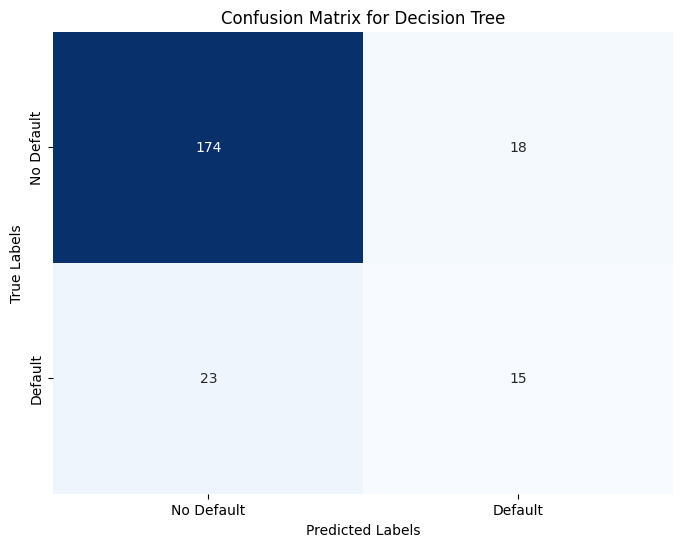

In [32]:
# Step 10: Create and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

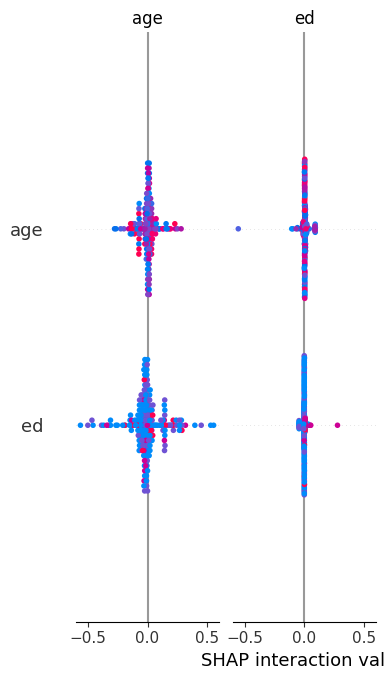

In [33]:
# Step 11: Interpret the model results (using SHAP)
if best_model_name in ["Decision Tree", "K-Nearest Neighbors"]:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
else:
    explainer = shap.KernelExplainer(best_model.predict, X_test)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar")

In [34]:
# Step 12: Save the best model for future use
model_filename = f"{best_model_name.replace(' ', '_').lower()}_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Model saved as '{model_filename}'")

Model saved as 'decision_tree_model.pkl'
